In [1]:
import uproot
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from collections import namedtuple, defaultdict
import open3d as o3d
import random
random.seed(42)
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import add_self_loops
from torch_geometric.transforms import ToUndirected
from torchvision import transforms
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib

In [2]:
hf_cellFeaturesScaled_neighbor= h5py.File("./cellFeaturesScaled_neighbor.hdf5", 'r')
hf_train_edge_source_BD = h5py.File("./train_edge_source_BD.hdf5", 'r')
hf_test_edge_source_BD = h5py.File("./test_edge_source_BD.hdf5", 'r')
hf_train_edge_dest_BD = h5py.File("./train_edge_dest_BD.hdf5", 'r')
hf_test_edge_dest_BD = h5py.File("./test_edge_dest_BD.hdf5", 'r')
hf_train_edge_source_noBD = h5py.File("./train_edge_source_noBD.hdf5", 'r')
hf_test_edge_source_noBD = h5py.File("./test_edge_source_noBD.hdf5", 'r')
hf_train_edge_dest_noBD = h5py.File("./train_edge_dest_noBD.hdf5", 'r')
hf_test_edge_dest_noBD = h5py.File("./test_edge_dest_noBD.hdf5", 'r')
hf_truth_label_train_neighbor= h5py.File("./truth_label_train_neighbor.hdf5", 'r')
hf_truth_label_test_neighbor= h5py.File("./truth_label_test_neighbor.hdf5", 'r')

In [3]:
cellFeaturesScaled = hf_cellFeaturesScaled_neighbor.get("cellFeaturesScaled")[:]
train_edge_source_BD = hf_train_edge_source_BD.get("train_edge_source_BD")[:]
test_edge_source_BD = hf_test_edge_source_BD.get("test_edge_source_BD")[:]
train_edge_dest_BD = hf_train_edge_dest_BD.get("train_edge_dest_BD")[:]
test_edge_dest_BD = hf_test_edge_dest_BD.get("test_edge_dest_BD")[:]
train_edge_source_noBD = hf_train_edge_source_noBD.get("train_edge_source_noBD")[:]
test_edge_source_noBD = hf_test_edge_source_noBD.get("test_edge_source_noBD")[:]
train_edge_dest_noBD = hf_train_edge_dest_noBD.get("train_edge_dest_noBD")[:]
test_edge_dest_noBD = hf_test_edge_dest_noBD.get("test_edge_dest_noBD")[:]
truth_label_train = hf_truth_label_train_neighbor.get("truth_label_train")[:]
truth_label_test = hf_truth_label_test_neighbor.get("truth_label_test")[:]

In [4]:
hf_cellFeaturesScaled_neighbor.close()
hf_train_edge_source_BD.close()
hf_test_edge_source_BD.close()
hf_train_edge_dest_BD.close()
hf_test_edge_dest_BD.close()
hf_train_edge_source_noBD.close()
hf_test_edge_source_noBD.close()
hf_train_edge_dest_noBD.close()
hf_test_edge_dest_noBD.close()
hf_truth_label_train_neighbor.close()
hf_truth_label_test_neighbor.close()

In [5]:
x = torch.tensor(cellFeaturesScaled, dtype=torch.float)

In [6]:
x.shape

torch.Size([187652, 8])

In [7]:
edge_index = torch.tensor([train_edge_source_BD, train_edge_dest_BD], dtype=torch.long)

/var/folders/k8/cklb1sxj1p35mft4gbkymsc091k_dc/T/ipykernel_44040/3333317026.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  edge_index = torch.tensor([train_edge_source_BD, train_edge_dest_BD], dtype=torch.long)


In [8]:
edge_index.shape

torch.Size([2, 700000])

In [9]:
edge_index_out = torch.tensor([train_edge_source_noBD, train_edge_dest_noBD], dtype=torch.long)

In [10]:
truth_label_train = np.expand_dims(truth_label_train, axis=1)

In [11]:
truth_label_train.shape

(350000, 1)

In [12]:
y_train = torch.tensor(truth_label_train, dtype=torch.float)

In [13]:
y_test = torch.tensor(truth_label_test, dtype=torch.float)

In [14]:
y_train.shape

torch.Size([350000, 1])

In [15]:
y_test.shape

torch.Size([150000])

In [16]:
# Ensure that bidirectional edges are treated correctly
edge_index, _ = add_self_loops(edge_index)

# Create a PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index, y=y_train)
data = ToUndirected()(data)

In [17]:
data.edge_index.shape

torch.Size([2, 887638])

In [18]:
data.y.shape

torch.Size([350000, 1])

In [19]:
x.size(1)

8

In [62]:
# Define the GNN model for edge classification
class EdgeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(EdgeClassifier, self).__init__()

        # Node embedding layer
        self.node_embedding = nn.Linear(input_dim, hidden_dim)

        # Graph convolutional layers
        self.conv1 = GCNConv(hidden_dim, 128)
        self.conv2 = GCNConv(128, 64)
    
        # Edge classification layer
        self.fc = nn.Linear(128 , output_dim)

    def forward(self, x, edge_index, edge_index_out):
        edge_index = edge_index
        x = self.node_embedding(x)
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)

        # Edge representations
        edge_index_to_compare = edge_index_out
        edge_rep = torch.cat([x[edge_index_to_compare[0]], x[edge_index_to_compare[1]]], dim=1)

        # Edge classification
        edge_scores = torch.sigmoid(self.fc(edge_rep))

        return edge_scores

In [63]:
# Instantiate the model
input_dim = x.size(1)
hidden_dim = 256
output_dim = 1  # Binary classification (citing or not citing)
model = EdgeClassifier(input_dim, hidden_dim, output_dim)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [64]:
# Training the model
num_epochs = 400
Loss =[]
for epoch in range(num_epochs):
    optimizer.zero_grad()
    edge_scores = model(data.x, data.edge_index, edge_index_out)
    loss = criterion(edge_scores, data.y)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        Loss.append(loss.item())
        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')


Epoch 0/400, Loss: 0.7112224698066711
Epoch 10/400, Loss: 0.5646250247955322
Epoch 20/400, Loss: 0.5162728428840637
Epoch 30/400, Loss: 0.4904589354991913
Epoch 40/400, Loss: 0.46999093890190125
Epoch 50/400, Loss: 0.4456574618816376
Epoch 60/400, Loss: 0.5389180183410645
Epoch 70/400, Loss: 0.4798724949359894
Epoch 80/400, Loss: 0.43912482261657715
Epoch 90/400, Loss: 0.40814340114593506
Epoch 100/400, Loss: 0.4917142987251282
Epoch 110/400, Loss: 0.45872893929481506
Epoch 120/400, Loss: 0.4338459074497223
Epoch 130/400, Loss: 0.41201186180114746
Epoch 140/400, Loss: 0.39236724376678467
Epoch 150/400, Loss: 0.37373021245002747
Epoch 160/400, Loss: 0.35776326060295105
Epoch 170/400, Loss: 0.38945308327674866
Epoch 180/400, Loss: 0.3478461802005768
Epoch 190/400, Loss: 0.33631277084350586
Epoch 200/400, Loss: 0.3288777768611908
Epoch 210/400, Loss: 0.3259153962135315
Epoch 220/400, Loss: 0.32553762197494507
Epoch 230/400, Loss: 0.33378687500953674
Epoch 240/400, Loss: 0.3435247540473938

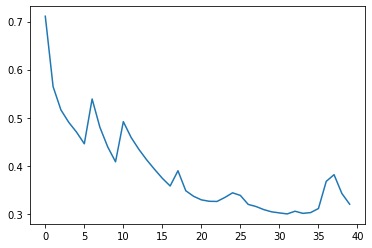

In [78]:
plt.plot(Loss)
plt.show()

In [79]:
edge_index_test = torch.tensor([test_edge_source_BD, test_edge_dest_BD], dtype=torch.long)
edge_index_test_out = torch.tensor([test_edge_source_noBD, test_edge_dest_noBD], dtype=torch.long)

In [80]:
# Ensure that bidirectional edges are treated correctly
edge_index_test_loop, _ = add_self_loops(edge_index_test)

In [81]:
# Evaluate the model on the test set
with torch.no_grad():
    model.eval()
    test_edge_scores = model(data.x, edge_index_test_loop, edge_index_test_out)

In [82]:
test_edge_scores[0]

tensor([0.2016])

In [83]:
test_edge_scores_np = test_edge_scores.detach().numpy()

In [84]:
test_edge_scores_np

array([[0.20155497],
       [0.9935802 ],
       [1.        ],
       ...,
       [0.00575134],
       [0.12666175],
       [1.        ]], dtype=float32)

In [85]:
trueEdges= test_edge_scores_np[np.where(truth_label_test==1)]
falseEdges = test_edge_scores_np[np.where(truth_label_test==0)]

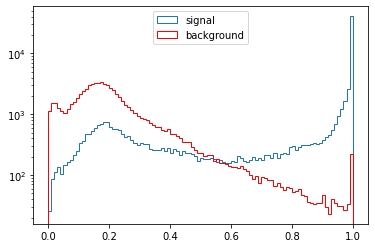

In [86]:
_=plt.hist(trueEdges,bins=100, histtype='step', label='signal')
                           
_=plt.hist(falseEdges,bins=100, histtype='step', color= 'red', label='background')

_=plt.yscale('log')

_=plt.legend(loc='upper center')

In [87]:
from sklearn.metrics import roc_curve, auc

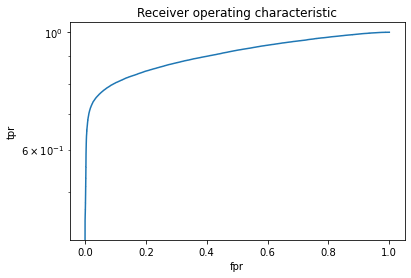

In [88]:
fpr, tpr, thresholds = roc_curve(truth_label_test,test_edge_scores_np)
plt.figure()
plt.plot(fpr, tpr)
#plt.plot(tpr, 1/fpr)
#plt.xlim([0.75, 1])
#plt.ylim([1, 10000])
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.title('Receiver operating characteristic')
plt.yscale('log')
plt.show()

In [89]:
auc(fpr, tpr)

0.9076443920355171

In [77]:
path = "/Users/bakshiguptad/ML/MLBasedCaloClusteringPipeLine/GNNCalo_net.pth"
torch.save(model, path)